In [1]:
print("hello")

hello


In [2]:
import time
from pprint import pprint
from IPython.display import display
from glob import glob
import re
import math
print("hello1")
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print("hello2")
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
print("hello3")
import torch
torch.set_default_dtype(torch.float64)
print("hello4")
import e3nn
print("hello5")
import e3nn.point.data_helpers as dh 
from training_utils import *
from variable_networks import VariableParityNetwork
print("bye")

hello1
hello2
hello3
hello4
hello5
bye


In [3]:
import psutil
print(psutil.virtual_memory())

svmem(total=405193338880, available=285271195648, percent=29.6, used=118650556416, free=230433202176, active=142075072512, inactive=24720535552, buffers=2322432, cached=56107257856, shared=86933504, slab=3221475328)


In [4]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
#print(torch.cuda.memory_summary())
device = "cuda"
#torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Tesla V100-PCIE-32GB
True
10.1


In [5]:
# all expected elements
all_elements = ['C', 'H', 'N', 'O', 'S']
n_elements = len(all_elements)

# so we can normalize training data for the nuclei to be predicted
elementwide_scaling_factors = { "C" : (118.0, 51.0),    # element : (mean, stdev)
                                "H" : (28.8, 3.0)  }
relevant_elements = list(elementwide_scaling_factors.keys())

# irrelevant atoms will not be scaled
for element in all_elements:
    if element not in elementwide_scaling_factors:
        elementwide_scaling_factors[element] = (0.0,1.0)

In [6]:
# create a function to noramlize the shieldings for a specific molecule
# shielding -> (shielding-mean)/stdev or 0 if not a relevant element
def get_scalings(atomic_symbols):
    scaling_factors = [ elementwide_scaling_factors[a] for a in atomic_symbols ]
    scaling_factors = np.array(scaling_factors)
    def scaling_function(x):
        result = x - scaling_factors[:,0]
        result = result / scaling_factors[:,1]
        return result
    return scaling_factors, scaling_function
    
# generates one-hots for a list of atomic_symbols
def get_one_hots(atomic_symbols):
    one_hots = []
    for symbol in atomic_symbols:
        inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
        one_hots.append(inner_list)
    return np.array(one_hots)

# compute weights for loss function
def get_weights(atomic_symbols, symmetrical_atoms):
    weights = [ 1.0 if symbol in relevant_elements else 0.0 for symbol in atomic_symbols ]
    weights = np.array(weights)
    for l in symmetrical_atoms:
        weight = 1.0/len(l)
        for i in l:
            weights[i] = weight
    return weights

In [7]:
# represents the training data for one molecule
# all of these items are stored on the cpu
class Molecule():
    def __init__(self, name,               
                 atomic_symbols,           
                 symmetrical_atoms,        # list of lists of 0-indexed atom numbers
                 perturbed_geometries,               
                 stationary_shieldings,
                 perturbed_shieldings):    
        self.name = name                                                     # name of molecule
        self.atomic_symbols = atomic_symbols                                 # vector of strings of length n_atoms
        self.n_atoms = len(atomic_symbols)                                   # number of atoms
        self.perturbed_geometries = perturbed_geometries                     # (n_examples, n_atoms, 3)
        self.stationary_shieldings = stationary_shieldings                   # (n_examples, n_atoms, 1)
        
        scaling_factors, scaling_function = get_scalings(atomic_symbols)
        self.scaling_factors = scaling_factors                               # (n_atoms, 2) inner axis is mean, stdev
        self.scaling_function = scaling_function                             # unscaled shieldings --> scaled shieldings 

        # scale perturbed shieldings and zero out data for irrelevant atoms
        perturbed_shieldings = self.scaling_function(perturbed_shieldings)
        for i,a in enumerate(atomic_symbols):
            if a not in relevant_elements:
                perturbed_shieldings[:,i]=0.0
        self.perturbed_shieldings = perturbed_shieldings                     # (n_examples, n_atoms, 1)
        
        self.features = get_one_hots(atomic_symbols)                         # (n_atoms, n_elements)
        self.weights = get_weights(atomic_symbols, symmetrical_atoms)        # (n_atoms,)

In [8]:
# with h5py.File("qm7_big.hdf5", "r") as h5:
#     for dataset_name,geometries_and_shieldings in h5.items():
#         if not dataset_name.startswith("data_"):
#             continue
#         dataset_number = dataset_name.split("_")[1]
#         geometries_and_shieldings = np.array(geometries_and_shieldings)
#         stationary_shieldings = h5.attrs[f"stationary_{dataset_number}"]
#         atomic_symbols = h5.attrs[f"atomic_symbols_{dataset_number}"]
#         print(f"{dataset_name}\t{np.shape(geometries_and_shieldings)}\t{len(stationary_shieldings)}\t{len(atomic_symbols)}\t", end='')
#         if np.shape(geometries_and_shieldings)[1] != len(stationary_shieldings) or \
#            len(stationary_shieldings) != len(atomic_symbols) or \
#            np.shape(geometries_and_shieldings)[1] != len(atomic_symbols):
#             print("mismatch",end='')
#         print()

In [168]:
molecules_dict = {}  # name -> Molecule
max_molecules=None
count=0
with h5py.File("qm7_big.hdf5", "r") as h5:
    for dataset_name,geometries_and_shieldings in h5.items():
        if not dataset_name.startswith("data_"):
            continue
        count += 1
        if count < 5:
            continue
        dataset_number = dataset_name.split("_")[1]
        n_molecules = len(molecules_dict)+1
        print(f"Processing molecule {n_molecules} ({dataset_name})...", end='\r', flush=True)
        geometries_and_shieldings = np.array(geometries_and_shieldings)
        perturbed_geometries = geometries_and_shieldings[1:11,:,:3]
        perturbed_shieldings = geometries_and_shieldings[1:11,:,3]
        assert np.shape(geometries_and_shieldings)[2] == 4
        stationary_shieldings = h5.attrs[f"stationary_{dataset_number}"]
        n_atoms = len(stationary_shieldings)
        assert np.shape(geometries_and_shieldings)[1] == n_atoms, f"expected {n_atoms} atoms, but got {np.shape(geometries_and_shieldings)[1]}"
        atomic_symbols = h5.attrs[f"atomic_symbols_{dataset_number}"]
        for a in atomic_symbols:
            assert a in all_elements, f"need to add {a} to all_elements"
        assert len(atomic_symbols) == n_atoms, f"expected {n_atoms} atoms, but got {len(atomic_symbols)}"
        symmetrical_atoms_group = h5.get(f"symmetrical_atoms_{dataset_number}")
        symmetrical_atoms = []
        for a,b in symmetrical_atoms_group.items():
            b = [ i-1 for i in b ]
            for i in b:
                assert 0 <= i < n_atoms
            symmetrical_atoms.append(b)    
        # store the results
        molecule = Molecule(dataset_number, atomic_symbols, symmetrical_atoms,
                            perturbed_geometries, stationary_shieldings, perturbed_shieldings)
        molecules_dict[dataset_number] = molecule
        if n_molecules == max_molecules:
            break

molecules = np.array(list(molecules_dict.values()))
print(f"\nDone.  {len(molecules)} molecules processed.")

Processing molecule 5239 (data_007164)...
Done.  5239 molecules processed.


(260880,)
0.01825852841901039
0.999062926671112
(451360,)
0.0151627332243274
0.7025934459164102


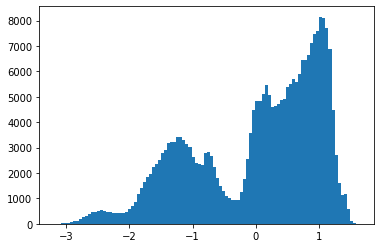

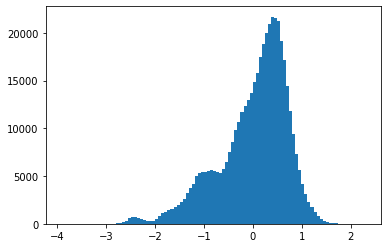

In [169]:
# get stats
all_shieldings = {}
for molecule in molecules:
    atomic_symbols = molecule.atomic_symbols
    perturbed_shieldings = molecule.perturbed_shieldings
    for i,symbol in enumerate(atomic_symbols):
        if symbol in relevant_elements:
            if symbol not in all_shieldings:
                all_shieldings[symbol] = []
            shieldings_list = all_shieldings[symbol]
            current_shieldings = shieldings_list.extend(perturbed_shieldings[:,i])
shieldingsC = all_shieldings["C"]
print(np.shape(shieldingsC))
print(np.mean(shieldingsC))
print(np.std(shieldingsC))
shieldingsH = all_shieldings["H"]
print(np.shape(shieldingsH))
print(np.mean(shieldingsH))
print(np.std(shieldingsH))
plt.hist(shieldingsC,bins=100)
plt.show()
plt.hist(shieldingsH,bins=100)
plt.show()

In [170]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_elements,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 5.0

In [171]:
def create_torch_dataset(molecules):
    dataset = []
    n_molecules = len(molecules)
    for i,molecule in enumerate(molecules):
        features = torch.tensor(molecule.features, dtype=torch.float64)
        #features.to(device)
        weights = torch.tensor(molecule.weights, dtype=torch.float64)
        #weights.to(device)
        n_to_save = len(molecule.perturbed_geometries)
        for j in range(n_to_save):
            if j == 0 or (j+1) % 50 == 0 or j == n_to_save - 1:
                print(f"Processing geometry {j+1:5d}/{n_to_save:5d} for molecule {molecule.name:5s} ({i+1:5d}/{n_molecules:5d})...           ", end='\r', flush=True)
            g = torch.tensor(molecule.perturbed_geometries[j,:,:], dtype=torch.float64)
            s = torch.tensor(molecule.perturbed_shieldings[j], dtype=torch.float64).unsqueeze(-1)  # [1,N]
            data = dh.DataNeighbors(x=features, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                    self_interaction=True, name=molecule.name,
                                    weights=weights, y=s, Rs_out = Rs_out)
            dataset.append(data)
    print("\ndone!")
    return dataset


In [172]:
# split into train and test molecules
# then preprocess the neighbor data
training_molecules, testing_molecules = train_test_split(molecules, train_size=5000, test_size=100, random_state=7)
training_dataset = create_torch_dataset(training_molecules)
testing_dataset = create_torch_dataset(testing_molecules)

Processing geometry    10/   10 for molecule 000781 ( 5000/ 5000)...           
done!
Processing geometry    10/   10 for molecule 000207 (  100/  100)...           
done!


In [173]:
# mean-squared loss
def loss_function(output, data):
    predictions = output
    observations = data.y
    weights = data.weights
    normalization = weights.sum()
    residuals = (predictions-observations)
    loss = residuals.square() * weights
    loss = loss.sum() / normalization
    #loss = loss.pow(0.5)
    return loss, residuals

In [199]:
# define the neural network architecture
#     def __init__(self, Rs_in, muls, Rs_out, lmaxes, #layers=3,
#                  max_radius=1.0, number_of_basis=3, radial_layers=3,
#                  feature_product=False, kernel=Kernel, convolution=Convolution):
# def model_from_kwargs(model_kwargs):
#     d = deepcopy(model_kwargs)
#     Network = eval(d.pop('network'))
#     Conv = eval(d.pop('conv'))
#     return Network(convolution=Conv, **d)
model_kwargs = {
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'muls': [2,3,4,5,6],            # how many copies of each tensor at each layer
    'lmaxes': [5,4,3,2,1],          # maximum angular momentum
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 50,     # number of Gaussians in radial kernel?
}
model = VariableParityNetwork(convolution=Convolution, **model_kwargs)
model.to(device);
n_parameters = len(list(model.parameters()))
print(f"There are {n_parameters} parameters.")

There are 30 parameters.


In [200]:
# # define the neural network architecture
# model_kwargs = {
#     'network': 'GatedConvParityNetwork', 
#     'conv': 'Convolution',
#     'Rs_in': Rs_in,            # shape of inputs
#     'Rs_out': Rs_out,          # shape of outputs
#     'mul': 3,                 # how many copies of each tensor at each layer
#     'lmax': 2,                 # maximum angular momentum
#     'layers': 3,               # number of layers
#     'max_radius': max_radius,  # radial kernel will extend out this far
#     'number_of_basis': 30,     # number of Gaussians in radial kernel?
# }
# model = model_from_kwargs(model_kwargs)
# model.to(device);

In [201]:
# training parameters
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), learning_rate)
epochs = 100       
n_norm = 14           # n_norm is average number of convolution neighbors per atom
batch_size = 50

In [202]:
# prepare to train model
torch.cuda.empty_cache()

training_size = len(training_dataset)
n_training_batches = int(training_size / batch_size)
training_dataloader = tg.data.DataListLoader(training_dataset, batch_size=batch_size, shuffle=True)

testing_size = len(testing_dataset)
n_testing_batches = int(testing_size / batch_size)
testing_dataloader = tg.data.DataListLoader(testing_dataset, batch_size=batch_size, shuffle=False)

results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
history = []      # index is epoch, items are (train_loss, test_loss)

In [203]:
# train model
zero_time = time.time()
start_time = time.time()
for i in range(epochs):
    start_time = time.time()
    
    # training
    training_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(training_dataloader):
        # forward pass
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        loss, residuals = loss_function(output, data)
        
        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # update training loss
        temp_loss = loss.detach()
        training_loss_cum += loss.detach() #.pow(2)
        current_cum = np.sqrt(training_loss_cum.item() / (j+1))
        print(f"Iteration {i+1:<4d}    train {j+1:5d} / {n_training_batches:5d}  loss = {np.sqrt(temp_loss.item()):12.3f}    cum_loss = {current_cum:12.3f}            ", end="\r", flush=True)
        
    training_loss_cum = np.sqrt((training_loss_cum.item()/(j+1)))
    
    # testing
    testing_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(testing_dataloader):
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        
        with torch.no_grad():
            # run model
            output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)

            # compute MSE
            loss, residuals = loss_function(output,data)
            testing_loss_cum += loss  #.pow(2)
        print(f"Iteration {i+1:<4d}    test {j+1:5d} / {n_testing_batches:5d}  loss = {np.sqrt(loss.item()):12.3f}                                  ", end="\r", flush=True)
    
    testing_loss_cum = np.sqrt((testing_loss_cum.item()/(j+1)))
    end_time = time.time()
    elasped_time = end_time - start_time
    elapsed_time2 = end_time - zero_time
    history.append((training_loss_cum, testing_loss_cum))
    print(f"Iteration {i+1:<4d}    training = {training_loss_cum.item():>12.3f}    testing = {testing_loss_cum.item():>12.3f}     elapsed = {elasped_time:7.2f} s   total = {elapsed_time2:11.2f} s                     ", end="\r", flush=True)
    print()
    #if i == 0 or (i+1) % 10 == 0:
    #    print()

Iteration 1       training =        8.567    testing =        4.688     elapsed = 1098.29 s   total =     1098.29 s                     
Iteration 2       training =        3.638    testing =        3.318     elapsed = 1099.25 s   total =     2197.55 s                     
Iteration 3       training =        2.761    testing =        2.817     elapsed = 1112.16 s   total =     3309.71 s                     
Iteration 4       training =        2.314    testing =        2.447     elapsed = 1112.06 s   total =     4421.77 s                     
Iteration 5       training =        2.033    testing =        2.229     elapsed = 1111.99 s   total =     5533.76 s                     
Iteration 6       training =        1.830    testing =        2.069     elapsed = 1111.42 s   total =     6645.18 s                     
Iteration 7       training =        1.672    testing =        1.977     elapsed = 1112.18 s   total =     7757.36 s                     
Iteration 8       training =        1.560

Iteration 60      training =        0.671    testing =        1.135     elapsed = 1097.46 s   total =    66024.54 s                     
Iteration 61      training =        0.666    testing =        1.108     elapsed = 1097.53 s   total =    67122.07 s                     
Iteration 62      training =        0.667    testing =        1.120     elapsed = 1097.43 s   total =    68219.50 s                     
Iteration 63      training =        0.660    testing =        1.093     elapsed = 1097.45 s   total =    69316.96 s                     
Iteration 64      training =        0.656    testing =        1.092     elapsed = 1097.54 s   total =    70414.50 s                     


KeyboardInterrupt: 

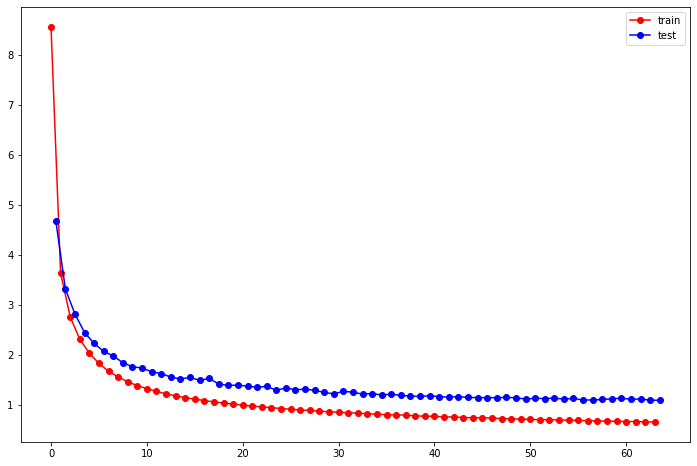

In [204]:
# plot learning curve
plt.figure(figsize=(12,8))
epoch = list(range(len(history)))
epoch = np.array(epoch)
epoch2 = epoch + 0.5
training_loss = [ training for training,testing in history ]
testing_loss = [ testing for training,testing in history ]
plt.plot(epoch, training_loss, "ro-", label="train")
plt.plot(epoch2, testing_loss, "bo-", label="test")
plt.legend(loc="best")
plt.show()

In [205]:
# test the model as it now
torch.cuda.empty_cache()
n_batches = math.ceil(testing_size / batch_size)
results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
start_time = time.time()

loss_cum = torch.tensor([0.]).to(device)
for j,data in enumerate(testing_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        # run model
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        
        # compute MSE
        loss, residuals = loss_function(output,data)
        loss_cum += loss #.pow(2)
        
        # rescale residuals back to ppm and store
        residuals = residuals.squeeze(-1).cpu().numpy()
        i=0
        for name in data.name:
            molecule = molecules_dict[name]
            n_atoms = molecule.n_atoms
            scaling_factors = molecule.scaling_factors
            if name not in results_dict:
                results_dict[name] = []
            subset = residuals[i:i+n_atoms] * scaling_factors[:,1]
            results_dict[name].append(subset)
            i += n_atoms
            
loss_cum = loss_cum/(j+1)
loss_cum = loss_cum.pow(0.5)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum.item():.6f}.  Evaluation took {elasped_time:.2f} s.")

batch    20 /    20
Overall loss is 1.091857.  Evaluation took 3.39 s.


In [206]:
# results_dict : molecule name -> residuals (n_examples,n_atoms)
# results_dict2 : site label -> residuals
results_dict2 = {}
all_residuals = {}  # element --> [residuals]
for name,results in results_dict.items():
    results = np.array(results).T
    molecule = molecules_dict[name]
    atomic_symbols = molecule.atomic_symbols
    for atomic_index,this_result in enumerate(results):
        element = atomic_symbols[atomic_index]
        if element not in relevant_elements:
            continue
        label = f"{name}_{element}{atomic_index+1}"
        results_dict2[label]=this_result
        if element not in all_residuals:
            all_residuals[element] = []
        all_residuals[element].extend(this_result)

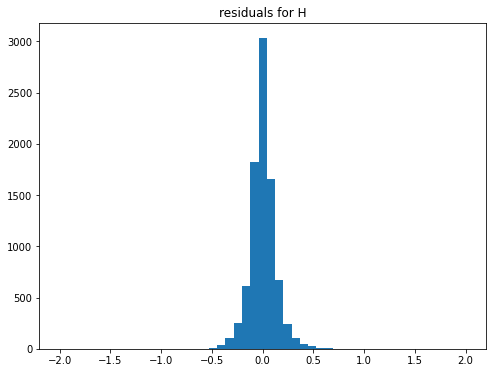

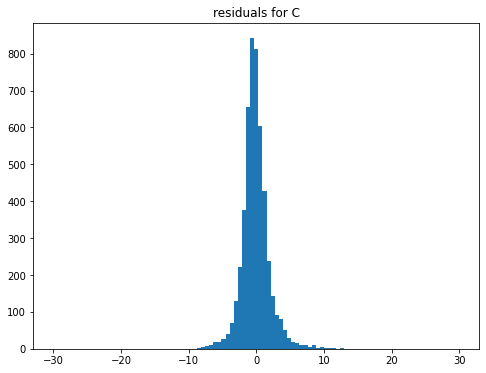

In [207]:
e="H"
bins = np.linspace(-2,2,50)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()
e="C"
bins = np.linspace(-30,30,100)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()

In [208]:
# get stats on everything
for e in relevant_elements:
    mean_error = np.mean(all_residuals[e])
    RMSE = np.sqrt(np.mean(np.square(all_residuals[e])))
    min_err = np.min(all_residuals[e])
    max_err = np.max(all_residuals[e])
    print(f"{e}:  mean ={mean_error:7.3f}  RMSE ={RMSE:7.3f}   range = {min_err:7.2f} to {max_err:7.2f}")

C:  mean = -0.125  RMSE =  1.995   range =   -8.76 to   12.53
H:  mean =  0.003  RMSE =  0.125   range =   -0.55 to    0.75


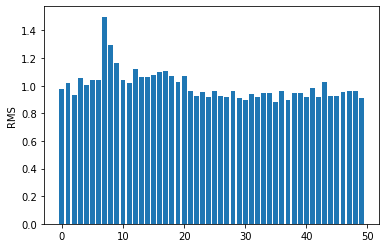

In [212]:
from diagnostics import *
show_radial_parameters(model, max_radius)

In [213]:
print_parameter_size(model)

layers.0.0.kernel.R.f.weights.0: [100, 50]
layers.0.0.kernel.R.f.weights.1: [100, 100]
layers.0.0.kernel.R.f.weights.2: [100, 100]
layers.0.0.kernel.R.f.weights.3: [110, 100]
layers.0.0.kernel.linear.weight: [60]
layers.1.0.kernel.R.f.weights.0: [100, 50]
layers.1.0.kernel.R.f.weights.1: [100, 100]
layers.1.0.kernel.R.f.weights.2: [100, 100]
layers.1.0.kernel.R.f.weights.3: [690, 100]
layers.1.0.kernel.linear.weight: [78]
layers.2.0.kernel.R.f.weights.0: [100, 50]
layers.2.0.kernel.R.f.weights.1: [100, 100]
layers.2.0.kernel.R.f.weights.2: [100, 100]
layers.2.0.kernel.R.f.weights.3: [1200, 100]
layers.2.0.kernel.linear.weight: [156]
layers.3.0.kernel.R.f.weights.0: [100, 50]
layers.3.0.kernel.R.f.weights.1: [100, 100]
layers.3.0.kernel.R.f.weights.2: [100, 100]
layers.3.0.kernel.R.f.weights.3: [960, 100]
layers.3.0.kernel.linear.weight: [200]
layers.4.0.kernel.R.f.weights.0: [100, 50]
layers.4.0.kernel.R.f.weights.1: [100, 100]
layers.4.0.kernel.R.f.weights.2: [100, 100]
layers.4.0.ker

In [216]:
def count_parameters(model):
    model_count_dict = {} # layer # -> n_params
    n_total_parameters = 0
    for name, param in model.named_parameters():
        n_params = np.prod(param.shape)
        n_total_parameters += n_params
        fields = name.split(".")
        layer = fields[1]
        if layer not in model_count_dict:
            model_count_dict[layer]=0
        model_count_dict[layer] += n_params
    for layer,n_params in model_count_dict.items():
        print(f"Layer {layer}: {n_params}")
    print(f"Total parameters: {n_total_parameters}")
count_parameters(model)        

Layer 0: 36060
Layer 1: 94078
Layer 2: 145156
Layer 3: 121200
Layer 4: 73180
Layer 5: 26206
Total parameters: 495880


In [ ]:
# summary stats
df = pd.DataFrame(results_dict2)
means = df.mean()
ranges = df.max()-df.min()
RMSEs = np.sqrt(df.pow(2).mean())
df = pd.concat([means,ranges,RMSEs], axis=1)
df.columns = ["mean","range","RMSE"]
df = df.round(2)
display(df)

In [209]:
def save_model(model_kwargs, model, filename, optimizer=None):
    model_dict = {
        'state_dict': model.state_dict(),
        'model_kwargs': model_kwargs
    }
    if optimizer is not None:
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(model_dict, filename)

In [210]:
save_model(model_kwargs, model, "qm7-mul23456-lmax54321-model1.torch", optimizer=opt)

In [ ]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 3,                 # how many copies of each tensor at each layer
    'lmax': 1,                 # maximum angular momentum
    'layers': 3,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel?
}
model = model_from_kwargs(model_kwargs)
model.to(device);